In [46]:
import math
from glob import glob
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
# from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (ElasticNetCV, LassoCV, LinearRegression,
                                  RidgeCV)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from xgboost import XGBRegressor


In [47]:
sns.set_theme(style="whitegrid", font="Verdana")

In [48]:
%matplotlib inline


# Functions

In [49]:
def show_heatmap(X: pd.DataFrame) -> None:
    """Plots heatmap of a dataset.

    Parameters
    ----------
    X : pd.DataFrame
        data frame
    """
    figure = plt.figure(figsize=(12, 12), dpi=120)
    subplot = figure.add_subplot()
    
    sns.heatmap(X.corr(method="spearman"), annot=True, linewidths=0.5, square=True)

    plt.show()


In [50]:
def show_boxplot(X: pd.DataFrame) -> None:
    """Plots boxplots of each feature in a dataset.

    Parameters
    ----------
    X : pd.DataFrame
        data frame
    """
    columns = 4
    rows = math.ceil(X.shape[1] / columns)

    figure = plt.figure(figsize=(rows * columns * 2, rows * columns * 2), dpi=120)
    figure.subplots_adjust(wspace=0.4, hspace=0.2)

    for index, column in enumerate(iterable=X.columns):
        subplot = figure.add_subplot(rows, columns, index + 1)

        boxplot = subplot.boxplot(x=column, data=X)
        subplot.set_title(label=column)

    plt.show()


In [51]:
def show_pairplot(X: pd.DataFrame, target_label: str, alpha: int = 0.1) -> None:
    """Plots pair plots of a dataset.

    Parameters
    ----------
    X : pd.DataFrame
        data frame
    target_label : str
        target column label
    alpha : float = 0.01
        transparency coefficient
    """
    row_index = 1

    rows = math.ceil(X.shape[1] / 2) + 1
    columns = 3

    plot_color = "red"
    mean_color = "lightgray"

    data_frame_columns = X.columns[:-1]

    figure = plt.figure()

    figure.subplots_adjust(wspace=0.4, hspace=0.4)
    figure.set_size_inches(w=16, h=32)
    figure.set_dpi(val=120)

    for index in range(len(data_frame_columns)):
        index *= 2

        if index + 1 < len(data_frame_columns):
            subplot = figure.add_subplot(rows, columns, row_index)
            subplot.set(
                xlabel=data_frame_columns[index], ylabel=data_frame_columns[index + 1]
            )
            subplot.grid(False)
            subplot.scatter(
                x=X[data_frame_columns[index]],
                y=X[data_frame_columns[index + 1]],
                c=plot_color,
                alpha=alpha,
            )
            subplot.axvline(x=np.mean(X[data_frame_columns[index]]), c=mean_color)
            subplot.axhline(y=np.mean(X[data_frame_columns[index + 1]]), c=mean_color)

            subplot = figure.add_subplot(rows, columns, row_index + 2)
            subplot.set(xlabel=data_frame_columns[index + 1], ylabel=target_label)
            subplot.grid(False)
            subplot.scatter(
                x=X[data_frame_columns[index + 1]],
                y=X[target_label],
                c=plot_color,
                alpha=alpha,
            )
            subplot.axvline(x=np.mean(X[data_frame_columns[index + 1]]), c=mean_color)

        if index < len(data_frame_columns):
            subplot = figure.add_subplot(rows, columns, row_index + 1)
            subplot.set(xlabel=data_frame_columns[index], ylabel=target_label)
            subplot.grid(False)
            subplot.scatter(
                x=X[data_frame_columns[index]],
                y=X[target_label],
                c=plot_color,
                alpha=alpha,
            )
            subplot.axvline(x=np.mean(X[data_frame_columns[index]]), c=mean_color)

        row_index += columns

    # Lines indicate mean values
    plt.show()


In [52]:
def show_linear_metrics(y_true: np.array, y_pred: np.array) -> None:
    """Prints linear metrics.

    Parameters
    ----------
    y_true : np.array
        y true
    y_pred : np.array
        y predicted
    """
    print("Mean Absolute Error:", mean_absolute_error(y_true=y_true, y_pred=y_pred))
    print("Mean Squared Error:", mean_squared_error(y_true=y_true, y_pred=y_pred))
    print(
        "Root Mean Squared Error:",
        mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False),
    )
    print("R^2 Score:", r2_score(y_true=y_true, y_pred=y_pred))


# [Dataset](https://drive.google.com/drive/folders/1nfrYxDm7TLzls9pedZbLX5rP4McVDWDe)

In [77]:
DATASET_PATH = "SSD2022AS2"


In [78]:
csv_files = glob(pathname=path.join(DATASET_PATH, "*.csv"), recursive=True)


In [79]:
dfs = list()

for csv_file in csv_files:
    dfs.append(pd.read_csv(filepath_or_buffer=csv_file))


In [80]:
df = pd.concat(objs=dfs).reset_index(drop=True)


In [81]:
df.timestamp = pd.to_datetime(df.timestamp)


In [82]:
df

,client_user_id,session_id,dropped_frames,FPS,bitrate,RTT,timestamp,device
0,1762b87a-b2ab-4caa-8b90-0c576e425b7d,bc369f3e-0ea4-46c2-b213-0e1d33d56734,0.0,29.0,724.0,211.0,2022-09-19 09:00:25,Mac
1,1762b87a-b2ab-4caa-8b90-0c576e425b7d,bc369f3e-0ea4-46c2-b213-0e1d33d56734,0.0,30.0,538.0,224.0,2022-09-19 09:00:30,Mac
2,1762b87a-b2ab-4caa-8b90-0c576e425b7d,bc369f3e-0ea4-46c2-b213-0e1d33d56734,0.0,30.0,623.0,214.0,2022-09-19 09:00:35,Mac
3,1762b87a-b2ab-4caa-8b90-0c576e425b7d,bc369f3e-0ea4-46c2-b213-0e1d33d56734,0.0,30.0,557.0,212.0,2022-09-19 09:00:40,Mac
4,1762b87a-b2ab-4caa-8b90-0c576e425b7d,bc369f3e-0ea4-46c2-b213-0e1d33d56734,0.0,30.0,575.0,211.0,2022-09-19 09:00:45,Mac
...,...,...,...,...,...,...,...,...
4035057,f6f86425-8aea-4488-9401-84297b985d06,ff77108b-ee99-4014-a6b2-b4bf7a817516,0.0,30.0,557.0,257.0,2022-09-02 17:07:15,Windows
4035058,f6f86425-8aea-4488-9401-84297b985d06,ff77108b-ee99-4014-a6b2-b4bf7a817516,0.0,30.0,520.0,259.0,2022-09-02 17:07:20,Windows
4035059,f6f86425-8aea-4488-9401-84297b985d06,ff77108b-ee99-4014-a6b2-b4bf7a817516,0.0,24.0,446.0,250.0,2022-09-02 17:07:25,Windows
4035060,f6f86425-8aea-4488-9401-84297b985d06,ff77108b-ee99-4014-a6b2-b4bf7a817516,0.0,28.0,1857.0,250.0,2022-09-02 17:07:30,Windows


# Stream Quality

# Next Session Time

In [83]:
df_ = df.copy()

In [104]:
df = df_.groupby(by=["client_user_id", "session_id"]).aggregate(
    {   "dropped_frames": [np.mean, np.std, np.max],
        "FPS": [np.mean, np.std],
        "bitrate": [np.mean, np.std],
        "RTT": [np.mean, np.std],
        "timestamp": [np.ptp, np.min],
    }, as_index=False
)
df

dropped_frames  \
                                                                                    mean   
client_user_id                       session_id                                            
003c2e7e-4392-4d01-81bb-93f2cce29f0b 8d39d204-d510-43cd-bf49-4df53f5ca0a5       9.166667   
004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a 10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf       0.510345   
006e829c-f656-4836-bc04-bafec3901fdc 11542f15-f5f2-4a02-9344-f0bbc8ad06ad       1.359472   
                                     38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180       1.276265   
                                     da0de052-ba6f-4f2c-8053-28d1cdcc0686       0.895911   
...                                                                                  ...   
ff5c29dc-94cf-4e36-8550-d9a2583ca439 ae9d4b9f-66fe-432d-8f80-0f32932a5be0       1.073446   
                                     c2ae6769-20a1-4086-817a-877afe436855       0.488956   
ff6840c7-06cc-4b09-89d9-fb680aed5385 641534d9-3328-49d3-b411-fa3ac736045b       0.516746   
ff88bb69-10c4-41d5-83a7-96663f165c33 2a296f3e-d81f-475d-9d35-6843f91b6e3d       0.000000   
ffbeddd5-ca3f-4bda-9e93-8b3e9c792bd4 795832de-87ac-48db-a738-c77842d26338      24.102041   

                                                                                      \
                                                                                 std   
client_user_id                       session_id                                        
003c2e7e-4392-4d01-81bb-93f2cce29f0b 8d39d204-d510-43cd-bf49-4df53f5ca0a5  27.891519   
004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a 10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf   6.243930   
006e829c-f656-4836-bc04-bafec3901fdc 11542f15-f5f2-4a02-9344-f0bbc8ad06ad   7.448480   
                                     38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180   8.476644   
                                     da0de052-ba6f-4f2c-8053-28d1cdcc0686   5.379302   
...                                                                              ...   
ff5c29dc-94cf-4e36-8550-d9a2583ca439 ae9d4b9f-66fe-432d-8f80-0f32932a5be0   9.303185   
                                     c2ae6769-20a1-4086-817a-877afe436855   5.222764   
ff6840c7-06cc-4b09-89d9-fb680aed5385 641534d9-3328-49d3-b411-fa3ac736045b   5.284316   
ff88bb69-10c4-41d5-83a7-96663f165c33 2a296f3e-d81f-475d-9d35-6843f91b6e3d   0.000000   
ffbeddd5-ca3f-4bda-9e93-8b3e9c792bd4 795832de-87ac-48db-a738-c77842d26338  26.853961   

                                                                                  \
                                                                            amax   
client_user_id                       session_id                                    
003c2e7e-4392-4d01-81bb-93f2cce29f0b 8d39d204-d510-43cd-bf49-4df53f5ca0a5  159.0   
004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a 10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf   92.0   
006e829c-f656-4836-bc04-bafec3901fdc 11542f15-f5f2-4a02-9344-f0bbc8ad06ad   72.0   
                                     38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180   86.0   
                                     da0de052-ba6f-4f2c-8053-28d1cdcc0686   38.0   
...                                                                          ...   
ff5c29dc-94cf-4e36-8550-d9a2583ca439 ae9d4b9f-66fe-432d-8f80-0f32932a5be0  148.0   
                                     c2ae6769-20a1-4086-817a-877afe436855   75.0   
ff6840c7-06cc-4b09-89d9-fb680aed5385 641534d9-3328-49d3-b411-fa3ac736045b   58.0   
ff88bb69-10c4-41d5-83a7-96663f165c33 2a296f3e-d81f-475d-9d35-6843f91b6e3d    0.0   
ffbeddd5-ca3f-4bda-9e93-8b3e9c792bd4 795832de-87ac-48db-a738-c77842d26338   69.0   

                                                                                 FPS  \
                                                                                mean   
client_user_id                       session_id                                        
003c2e7e-4392-4d01-81bb-93f2cce29f0b 8d39d204-d510-43cd-bf49-4df53f5ca0a5  44.337719   
004a4a88-03ec-4f2e-a0a3

In [155]:
df = df_.groupby(by=["client_user_id", "session_id"], as_index=False).aggregate(
    {   "dropped_frames": [np.mean, np.std, np.max],
        "FPS": [np.mean, np.std],
        "bitrate": [np.mean, np.std],
        "RTT": [np.mean, np.std],
        "timestamp": [np.ptp, np.min],
        }
)
df.columns = ["_".join(column).lower() for column in df.columns.to_flat_index()]
#df.loc[df["client_user_id_"] == df["client_user_id_"].iloc[4]].shape[0]
#df.apply(lambda x: (df.loc[df["client_user_id_"]] == x["client_user_id_"]).shape[0], axis=0)
df["timestamp_ptp"] = df["timestamp_ptp"].apply(lambda x: x.total_seconds())
df["user_ptp_avg"] = df.apply(lambda x: np.average(df["timestamp_ptp"].loc[df["client_user_id_"] == x["client_user_id_"]]), axis=1)
def f(x, df):
    subset = df.loc[df["client_user_id_"] == x["client_user_id_"]].sort_values(by = ["timestamp_ptp"])
    for index, row in subset.iterrows():
        if x["timestamp_amin"] < row["timestamp_amin"]:
            return row["timestamp_ptp"]
    return None

df["user_next_ptp"] = df.apply(lambda x: f(x, df), axis=1)
df

,client_user_id_,session_id_,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_ptp,timestamp_amin,user_ptp_avg,user_next_ptp
0,003c2e7e-4392-4d01-81bb-93f2cce29f0b,8d39d204-d510-43cd-bf49-4df53f5ca0a5,9.166667,27.891519,159.0,44.337719,18.079243,3883.149123,5381.456809,171.109649,277.138638,1135.0,2022-09-11 22:59:10,1135.000000,NaN
1,004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a,10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf,0.510345,6.243930,92.0,41.864368,12.710460,6415.157471,4366.984310,27.934483,11.900105,4355.0,2022-09-13 17:01:15,4355.000000,NaN
2,006e829c-f656-4836-bc04-bafec3901fdc,11542f15-f5f2-4a02-9344-f0bbc8ad06ad,1.359472,7.448480,72.0,29.026398,4.702089,17226.447205,5076.756036,58.000776,9.220387,6580.0,2022-09-20 21:00:25,4395.000000,NaN
3,006e829c-f656-4836-bc04-bafec3901fdc,38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180,1.276265,8.476644,86.0,39.822957,5.304531,3930.153696,1532.691830,54.888132,55.603848,5240.0,2022-09-20 16:45:40,4395.000000,6580.0
4,006e829c-f656-4836-bc04-bafec3901fdc,da0de052-ba6f-4f2c-8053-28d1cdcc0686,0.895911,5.379302,38.0,26.847584,4.424639,13372.773234,4410.790738,16.405204,8.144871,1365.0,2022-09-06 12:31:15,4395.000000,5240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,ff5c29dc-94cf-4e36-8550-d9a2583ca439,ae9d4b9f-66fe-432d-8f80-0f32932a5be0,1.073446,9.303185,148.0,25.733208,3.990694,1795.932831,1495.012451,260.524796,279.533438,8005.0,2022-09-26 13:37:20,4523.333333,4990.0
4282,ff5c29dc-94cf-4e36-8550-d9a2583ca439,c2ae6769-20a1-4086-817a-877afe436855,0.488956,5.222764,75.0,24.180723,2.892977,877.697791,1386.949540,297.836345,149.122790,4990.0,2022-09-29 04:30:55,4523.333333,NaN
4283,ff6840c7-06cc-4b09-89d9-fb680aed5385,641534d9-3328-49d3-b411-fa3ac736045b,0.516746,5.284316,58.0,31.019139,9.701785,977.622010,1123.739711,34.875598,18.736632,1065.0,2022-09-23 11:15:25,1065.000000,NaN
4284,ff88bb69-10c4-41d5-83a7-96663f165c33,2a296f3e-d81f-475d-9d35-6843f91b6e3d,0.000000,0.000000,0.0,29.213333,1.671398,1715.133333,1404.886018,76.031111,89.208243,1120.0,2022-09-28 16:23:25,1120.000000,NaN


In [101]:
df.columns = ["_".join(column).lower() for column in df.columns.to_flat_index()]
df

d___r___o___p___p___e___d_______f___r___a___m___e___s_______m___e___a___n  \
client_user_id                       session_id                                                                                                        
003c2e7e-4392-4d01-81bb-93f2cce29f0b 8d39d204-d510-43cd-bf49-4df53f5ca0a5                                           9.166667                           
004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a 10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf                                           0.510345                           
006e829c-f656-4836-bc04-bafec3901fdc 11542f15-f5f2-4a02-9344-f0bbc8ad06ad                                           1.359472                           
                                     38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180                                           1.276265                           
                                     da0de052-ba6f-4f2c-8053-28d1cdcc0686                                           0.895911                           
...                                                                                                                      ...                           
ff5c29dc-94cf-4e36-8550-d9a2583ca439 ae9d4b9f-66fe-432d-8f80-0f32932a5be0                                           1.073446                           
                                     c2ae6769-20a1-4086-817a-877afe436855                                           0.488956                           
ff6840c7-06cc-4b09-89d9-fb680aed5385 641534d9-3328-49d3-b411-fa3ac736045b                                           0.516746                           
ff88bb69-10c4-41d5-83a7-96663f165c33 2a296f3e-d81f-475d-9d35-6843f91b6e3d                                           0.000000                           
ffbeddd5-ca3f-4bda-9e93-8b3e9c792bd4 795832de-87ac-48db-a738-c77842d26338                                          24.102041                           

                                                                           d___r___o___p___p___e___d_______f___r___a___m___e___s_______s___t___d  \
client_user_id                       session_id                                                                                                    
003c2e7e-4392-4d01-81bb-93f2cce29f0b 8d39d204-d510-43cd-bf49-4df53f5ca0a5                                          27.891519                       
004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a 10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf                                           6.243930                       
006e829c-f656-4836-bc04-bafec3901fdc 11542f15-f5f2-4a02-9344-f0bbc8ad06ad                                           7.448480                       
                                     38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180                                           8.476644                       
                                     da0de052-ba6f-4f2c-8053-28d1cdcc0686                                           5.379302                       
...                                                                                                                      ...                       
ff5c29dc-94cf-4e36-8550-d9a2583ca439 ae9d4b9f-66fe-432d-8f80-0f32932a5be0                                           9.303185                       
                                     c2ae6769-20a1-4086-817a-877afe436855                                           5.222764                       
ff6840c7-06cc-4b09-89d9-fb680aed5385 641534d9-3328-49d3-b411-fa3ac736045b                                           5.284316                       
ff88bb69-10c4-41d5-83a7-96663f165c33 2a296f3e-d81f-475d-9d35-6843f91b6e3d                                           0.000000                       
ffbeddd5-ca3f-4bda-9e93-8b3e9c792bd4 795832de-87ac-48db-a738-c77842d26338                                          26.853961                       

                                                                           d___r___o___p___p___e___d_______f___r___a___m___e___s_______a___m___a___x  \
client_user_id       

In [61]:
df = df.reset_index(drop=True)


In [62]:
df.timestamp_ptp = df.timestamp_ptp.dt.total_seconds()


In [63]:
df = df.drop_duplicates()


In [64]:
# df.to_csv(path_or_buf="output.csv")


In [20]:
# ProfileReport(df=df).to_file(output_file="df.html")


In [65]:
df

,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_ptp
0,9.166667,27.891519,159.0,44.337719,18.079243,3883.149123,5381.456809,171.109649,277.138638,1135.0
1,0.510345,6.243930,92.0,41.864368,12.710460,6415.157471,4366.984310,27.934483,11.900105,4355.0
2,1.359472,7.448480,72.0,29.026398,4.702089,17226.447205,5076.756036,58.000776,9.220387,6580.0
3,1.276265,8.476644,86.0,39.822957,5.304531,3930.153696,1532.691830,54.888132,55.603848,5240.0
4,0.895911,5.379302,38.0,26.847584,4.424639,13372.773234,4410.790738,16.405204,8.144871,1365.0
...,...,...,...,...,...,...,...,...,...,...
4281,1.073446,9.303185,148.0,25.733208,3.990694,1795.932831,1495.012451,260.524796,279.533438,8005.0
4282,0.488956,5.222764,75.0,24.180723,2.892977,877.697791,1386.949540,297.836345,149.122790,4990.0
4283,0.516746,5.284316,58.0,31.019139,9.701785,977.622010,1123.739711,34.875598,18.736632,1065.0
4284,0.000000,0.000000,0.0,29.213333,1.671398,1715.133333,1404.886018,76.031111,89.208243,1120.0


# Data Engineering

In [21]:
df.describe()


,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_ptp
count,4.282000e+03,4.271000e+03,4.282000e+03,4282.000000,4271.000000,4282.000000,4271.000000,4282.000000,4271.000000,4282.000000
mean,2.591464e+05,6.080102e+05,3.168871e+06,32.477122,4.966321,6119.307007,2906.126261,77.756632,94.916235,4778.179589
std,9.028839e+06,1.618685e+07,7.223703e+07,10.088129,4.853093,4992.881843,2273.756675,125.891218,285.949036,5936.363825
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,27.297028,1.960906,2144.764640,1227.177982,19.078351,3.637369,1077.500000
50%,2.611425e-02,9.483725e-01,3.100000e+01,29.310317,3.574199,4946.960085,2360.359319,38.254994,11.635649,3010.000000
75%,4.751437e-01,5.107822e+00,6.700000e+01,36.820229,6.958262,8933.872698,4050.548469,85.256332,47.051631,6070.000000
max,4.131929e+08,6.069961e+08,1.952806e+09,90.781818,153.371647,40130.270531,19533.922478,2486.860000,6448.922735,98350.000000


In [22]:
df.isna().sum()


dropped_frames_mean     0
dropped_frames_std     11
dropped_frames_amax     0
fps_mean                0
fps_std                11
bitrate_mean            0
bitrate_std            11
rtt_mean                0
rtt_std                11
timestamp_ptp           0
dtype: int64

In [23]:
df[df.isna().any(axis=1)]


,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_ptp
450,0.0,NaN,0.0,30.0,NaN,10210.0,NaN,13.0,NaN,0.0
983,0.0,NaN,0.0,36.0,NaN,718.0,NaN,237.0,NaN,0.0
1016,0.0,NaN,0.0,5.0,NaN,1943.0,NaN,276.0,NaN,0.0
1035,0.0,NaN,0.0,5.0,NaN,1179.0,NaN,250.0,NaN,0.0
1062,0.0,NaN,0.0,0.0,NaN,1137.0,NaN,271.0,NaN,0.0
1959,0.0,NaN,0.0,23.0,NaN,5792.0,NaN,0.0,NaN,0.0
1994,0.0,NaN,0.0,29.0,NaN,4790.0,NaN,25.0,NaN,0.0
3289,0.0,NaN,0.0,24.0,NaN,4010.0,NaN,29.0,NaN,0.0
3508,0.0,NaN,0.0,30.0,NaN,0.0,NaN,0.0,NaN,0.0
3676,0.0,NaN,0.0,37.0,NaN,14.0,NaN,65.0,NaN,0.0


In [24]:
# df[:] = SimpleImputer().fit_transform(X=df)

df = df.replace(to_replace=np.nan, value=0)


findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


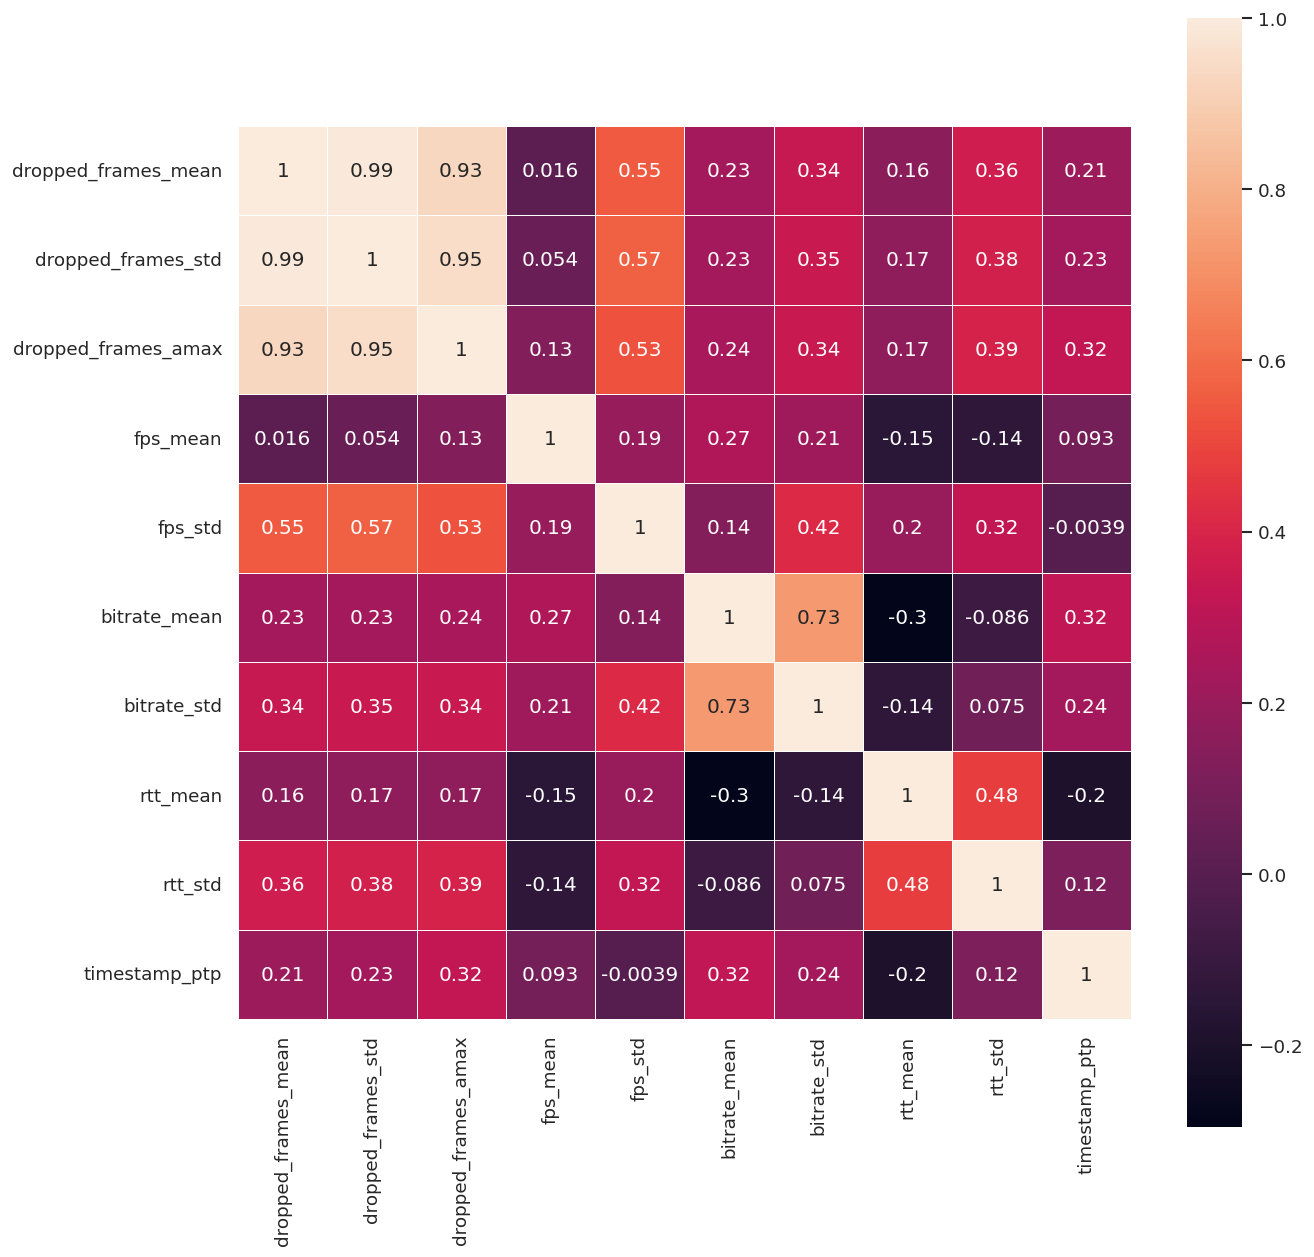

In [25]:
show_heatmap(X=df)


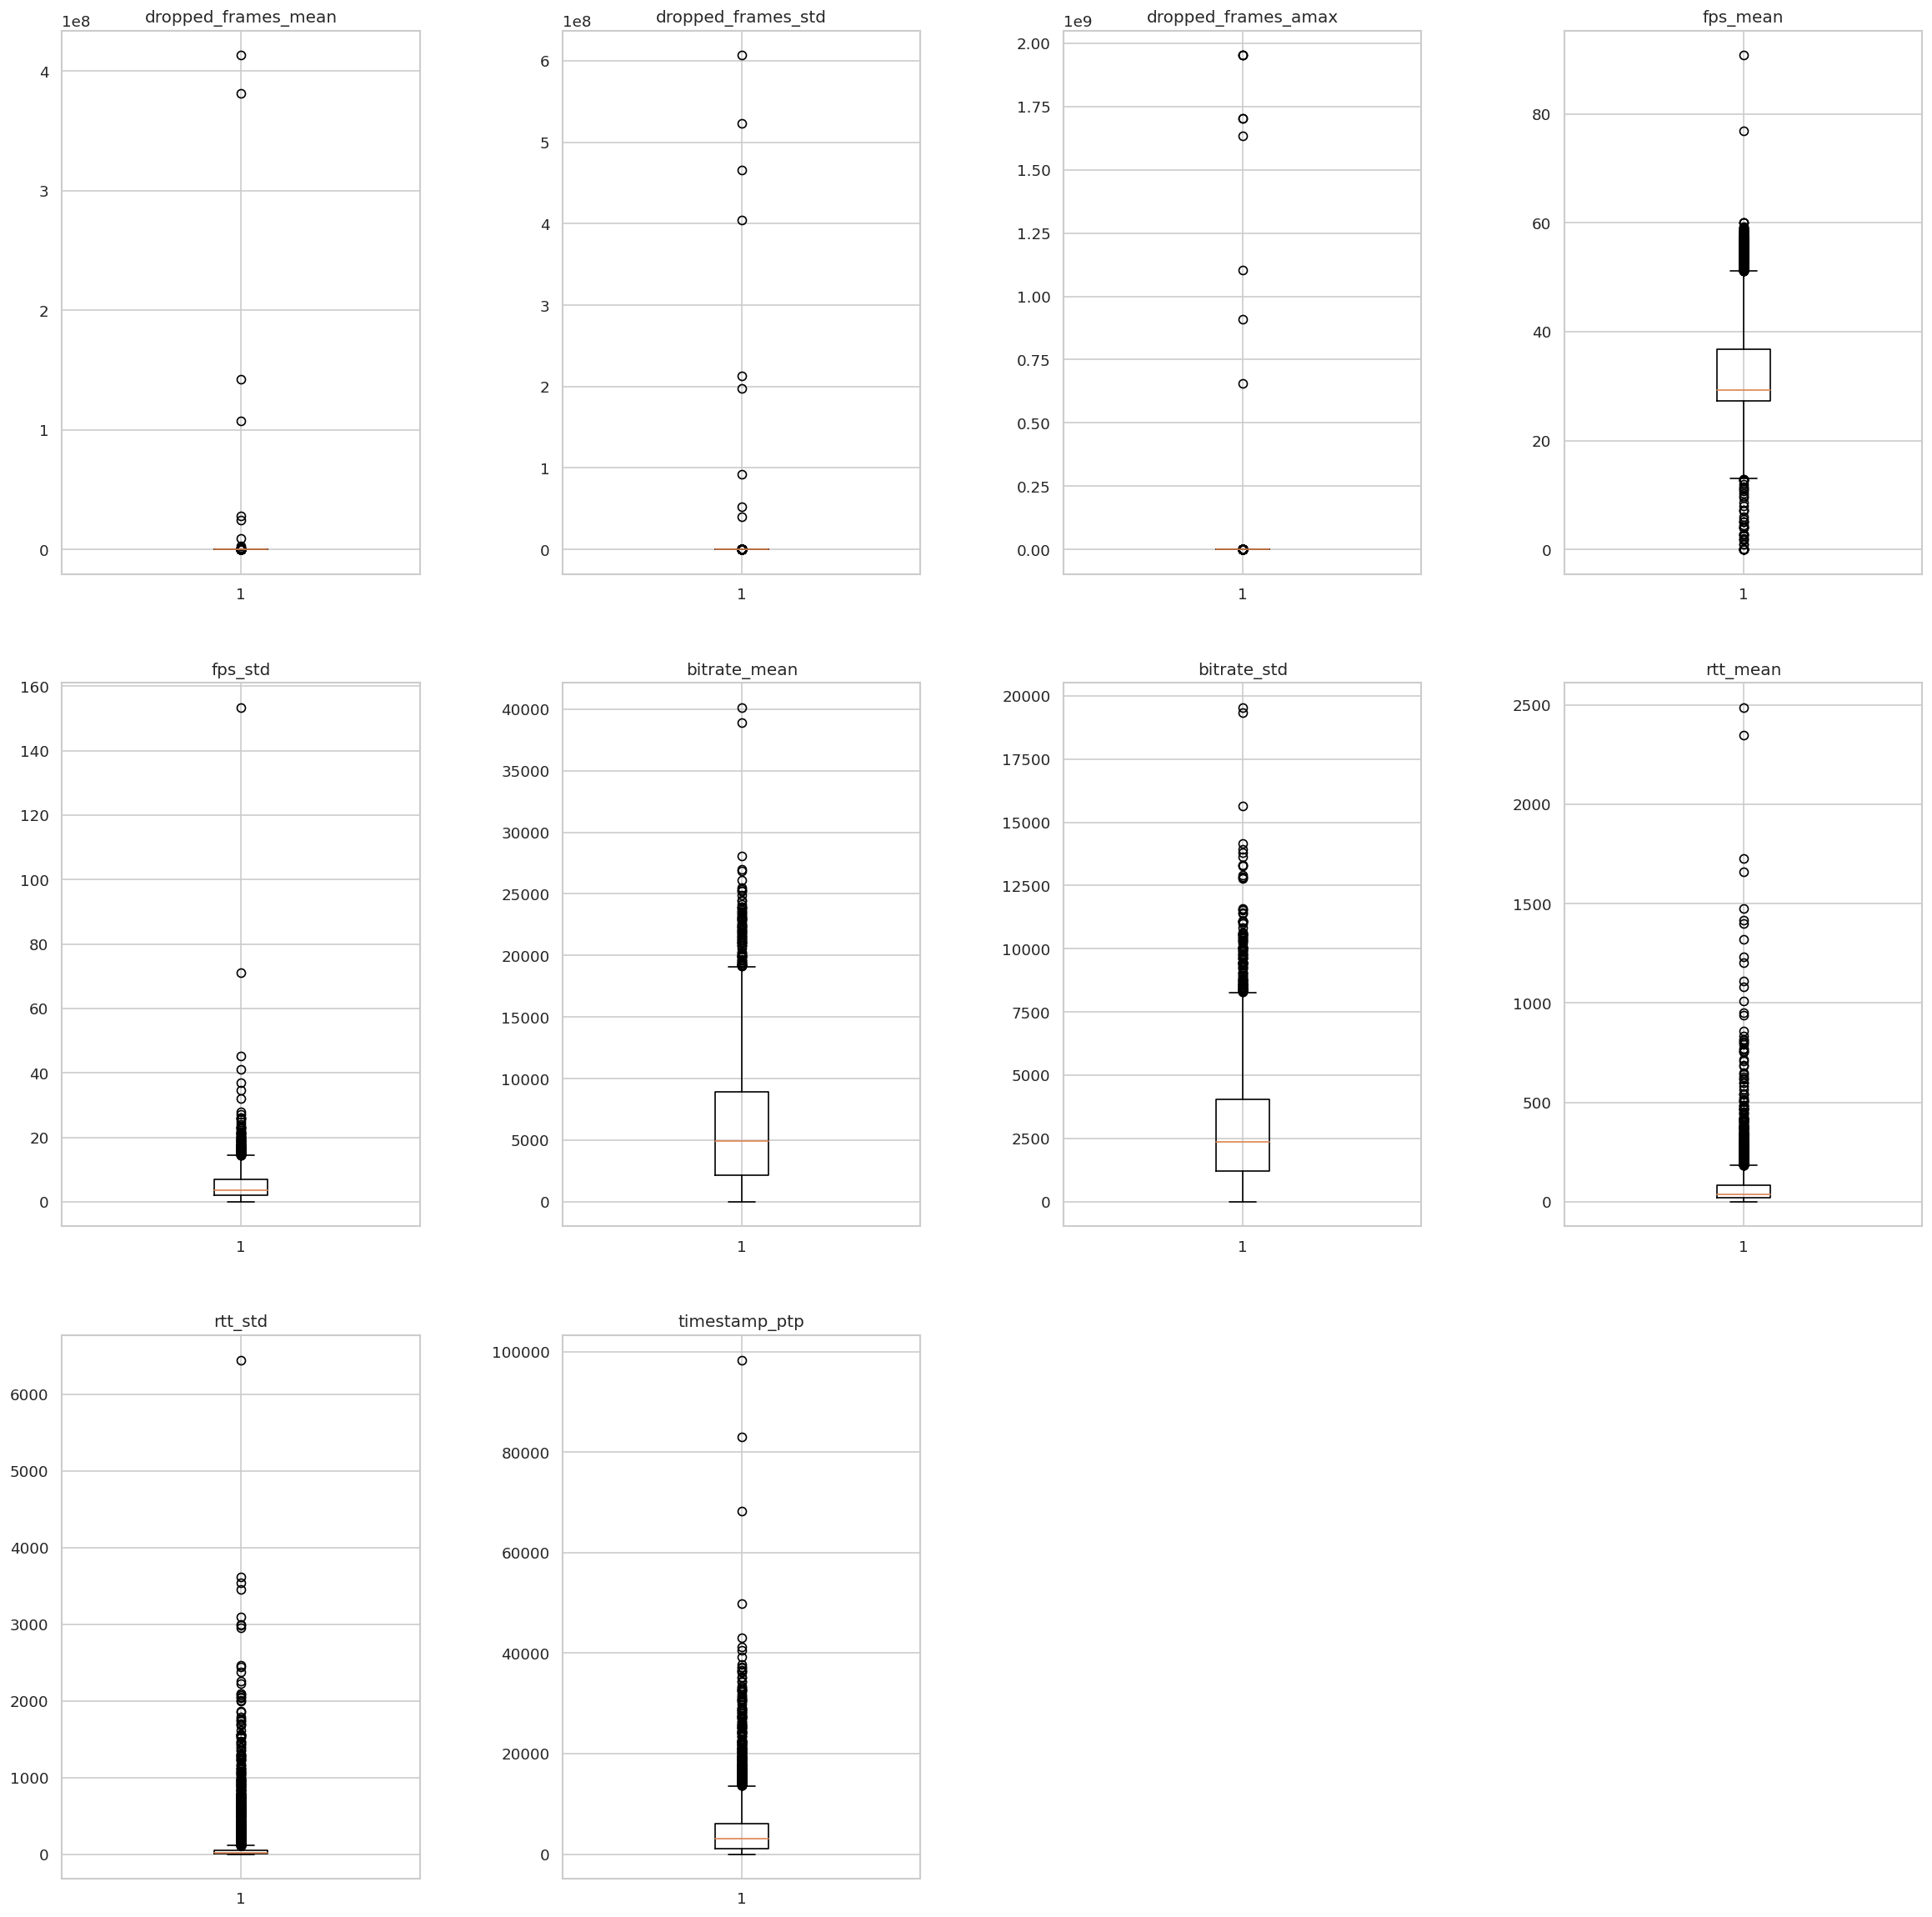

In [26]:
show_boxplot(X=df)


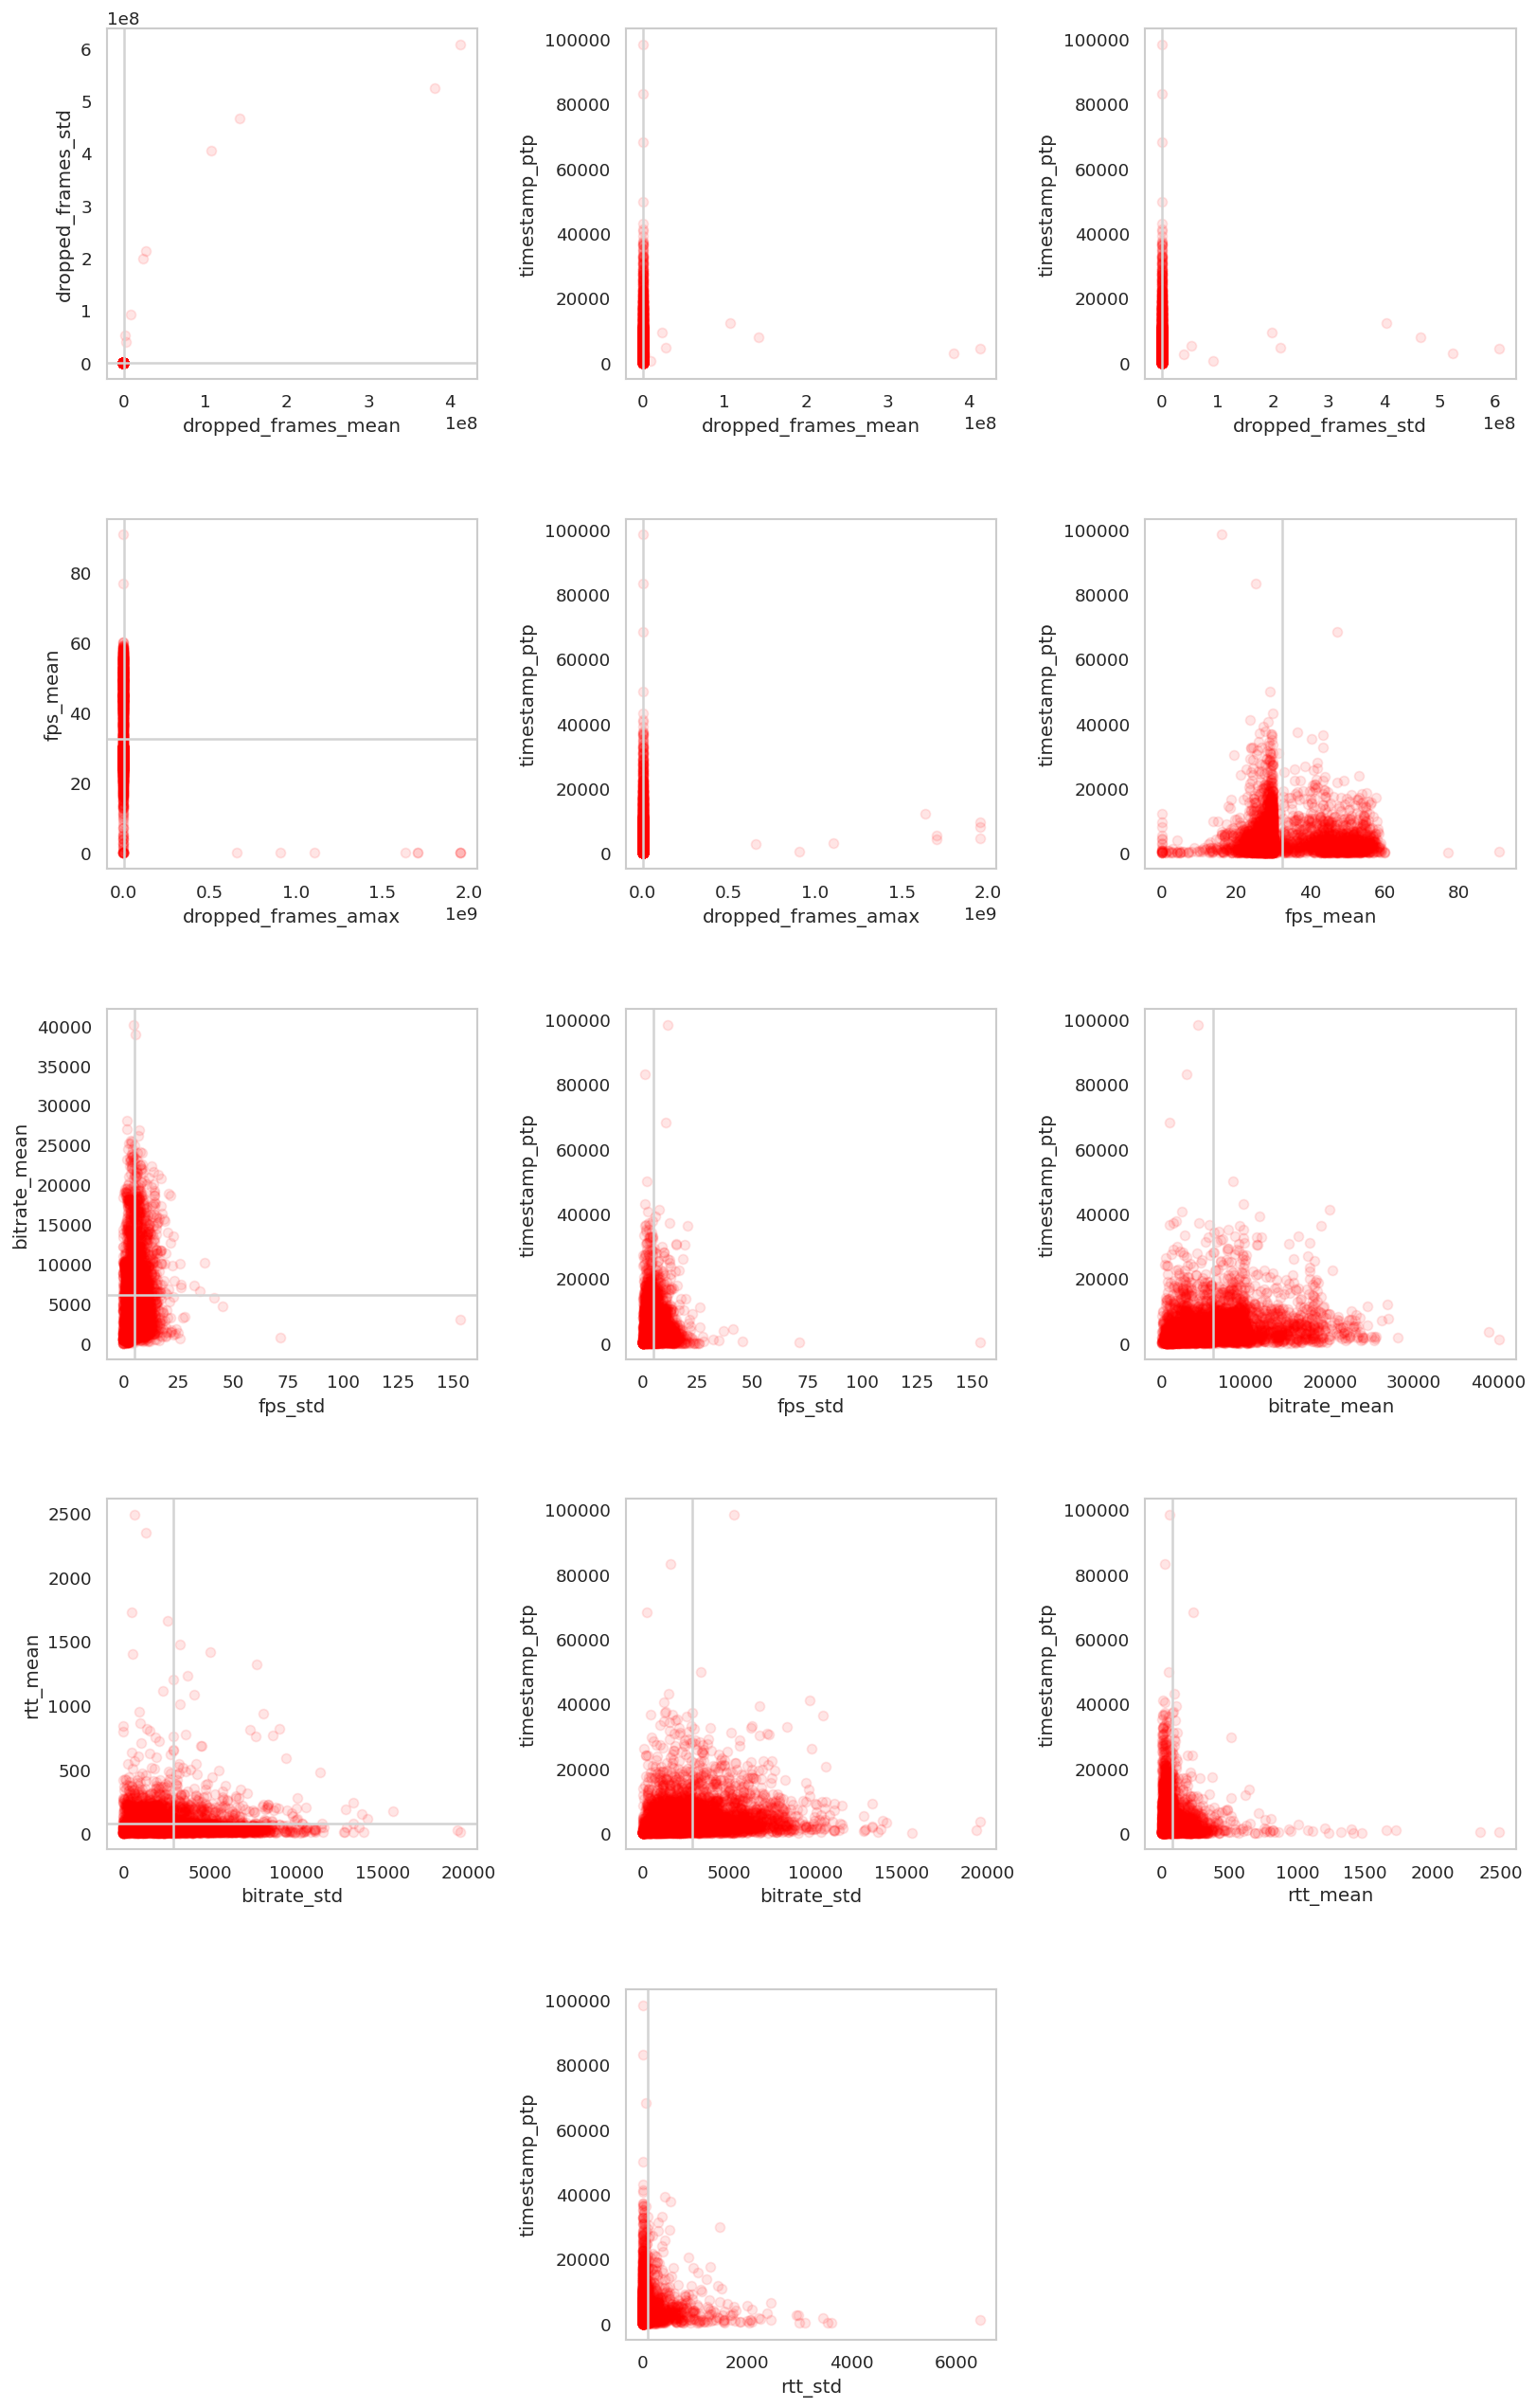

In [27]:
show_pairplot(X=df, target_label="timestamp_ptp")


In [28]:
df[df.columns[:-1]] = MinMaxScaler().fit_transform(X=df[df.columns[:-1]])


# Split

In [29]:
df_train, df_test = train_test_split(df, test_size=0.1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [30]:
# Outliers
# quantile = df_train.quantile(q=0.75)
# coef = 50

# for column in df_train.columns:
#     df_train = df_train.query(f"{column} < {quantile[column] * coef}")


In [31]:
df_train.shape


(3853, 10)

In [32]:
# X = X.drop(labels=["fps_mean", "fps_std", "rtt_mean", "rtt_std"], axis=1)


In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train = df_train.drop(labels=["timestamp_ptp"], axis=1)
X_test = df_test.drop(labels=["timestamp_ptp"], axis=1)

y_train = df_train.timestamp_ptp
y_test = df_test.timestamp_ptp


# Model

In [34]:
# pipeline = make_pipeline(PolynomialFeatures(), LassoCV(max_iter=10000))

# param_grid = {"polynomialfeatures__degree": np.arange(2, 5)}

# polynomial_regression = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring="r2",
#     cv=10,
#     return_train_score=True,
# )
# polynomial_regression.fit(X=X_train, y=y_train)

# y_pred = polynomial_regression.predict(X=X_test)

# print("Degree:", polynomial_regression.best_params_["polynomialfeatures__degree"])


In [35]:
# pipeline = make_pipeline(PolynomialFeatures(degree=2), LassoCV(max_iter=10000))
# pipeline.fit(X=X_train, y=y_train)

# y_pred = pipeline.predict(X=X_test)


In [36]:
# ridge_cv = RidgeCV()
# ridge_cv.fit(X=X_train, y=y_train)

# y_pred = ridge_cv.predict(X=X_test)


In [37]:
# random_forest = RandomForestRegressor()

# random_forest.fit(X=X_train, y=y_train)
# y_pred = random_forest.predict(X=X_test)


In [38]:
cb = CatBoostRegressor()
cb.fit(X=X_train, y=y_train)

y_pred = cb.predict(data=X_test)


Learning rate set to 0.050668
0:	learn: 6019.7522812	total: 47.7ms	remaining: 47.7s
1:	learn: 5978.8557912	total: 48.3ms	remaining: 24.1s
2:	learn: 5934.9014863	total: 49ms	remaining: 16.3s
3:	learn: 5890.8450760	total: 49.6ms	remaining: 12.3s
4:	learn: 5853.6770471	total: 50.2ms	remaining: 9.98s
5:	learn: 5814.3159908	total: 50.8ms	remaining: 8.41s
6:	learn: 5785.1672521	total: 51.4ms	remaining: 7.29s
7:	learn: 5758.8206761	total: 52ms	remaining: 6.45s
8:	learn: 5726.4070187	total: 52.6ms	remaining: 5.79s
9:	learn: 5698.2034366	total: 53.2ms	remaining: 5.27s
10:	learn: 5667.8703554	total: 53.9ms	remaining: 4.85s
11:	learn: 5635.2880818	total: 54.5ms	remaining: 4.49s
12:	learn: 5610.9285824	total: 55.1ms	remaining: 4.18s
13:	learn: 5585.8152458	total: 55.7ms	remaining: 3.92s
14:	learn: 5566.8671412	total: 56.4ms	remaining: 3.7s
15:	learn: 5542.5067545	total: 57ms	remaining: 3.5s
16:	learn: 5513.6459726	total: 57.7ms	remaining: 3.34s
17:	learn: 5491.3345167	total: 58.4ms	remaining: 3.18

In [39]:
# xgb = XGBRegressor()
# xgb.fit(X=X_train, y=y_train)

# y_pred = xgb.predict(X=X_test)


In [40]:
# svr = svm.SVR()

# svr.fit(X=X_train, y=y_train)
# y_pred = svr.predict(X=X_test)


In [41]:
# elastic_net_cv = ElasticNetCV()
# elastic_net_cv.fit(X=X_train, y=y_train)

# y_pred = elastic_net_cv.predict(X=X_test)


In [42]:
show_linear_metrics(y_true=y_test, y_pred=y_pred)


Mean Absolute Error: 2688.194009222303
Mean Squared Error: 14428803.217307635
Root Mean Squared Error: 3798.5264534168555
R^2 Score: 0.3165151948075361


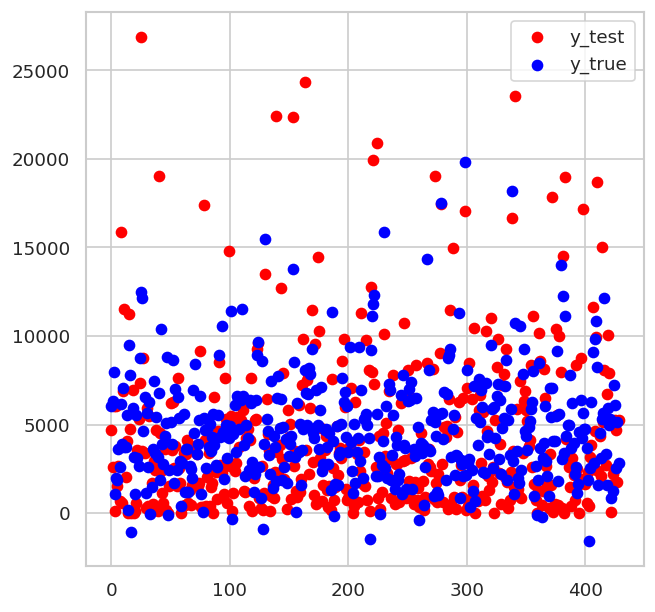

In [43]:
figure = plt.figure(figsize=(6, 6), dpi=120)
subplot = figure.add_subplot()

subplot.scatter(x=np.arange(len(y_test)), y=y_test, c="red", label="y_test")
subplot.scatter(x=np.arange(len(y_pred)), y=y_pred, c="blue", label="y_true")

plt.legend()
plt.show()


# Total Number of Bad Sessions